# **Meerkat Call Detection Framework**

This notebook allows you to go through the full process of training a CNN on meerkat calls, running the CNN on new files to extract potential calls, and then evaluating the effectiveness using ROC curves. You can go through all steps or perform a subset of them, but first choose which files you will be using for training and testing.

## Set parameters
Here, you set up the parameters needed for the training and testing. Run the cell below before you run the rest of the notebook!

**Directories**

All directories need to be accessible from your Google Drive.

*audio_dir*: This should contain 3 subfolders. 'calls' and 'noise' are folders where the call and noise snippets used for training are located. 'long_recordings' is where full audio files are

*groundtruth_dir*: This is the directory containing csv files of labeled data

*model_dir*: This directory contains fitted models

*output_dir*: This is where the output (.pckl and .csv files) will be stored

*code_dir*: Directory where code is stored

**Files**

*model_name*: file name for the output model, or for the model to load (in the case of using a pre-trained model)

**Training parameters**

*epochs*: number of epochs to train for

*batch_size*: batch size of data to use

*steps_per_epoch*: how many training steps per epoch

**Prediction parameters**

*audio_file*: name of audio file to run prediction on

*t_start*: start time for predictions within audio file (sec)

*t_end*: end time for predictions within audio file (sec)

**Other parameters (probably don't need to change)**

*samprate*: sample rate of audio file, should be 8000 for current code (code will likely not work with other sample rates!)

*chunk_size*: number of seconds to read in each time wav is accessed directly

*chunk_pad*: pad chunks of wavs on each end to avoid any issues - 1 sec is fine

In [2]:
#TODO: Fix evaluation, need to match up file names due to 8000_LEFT extension

#PARAMETERS - Modify parameters before running to change settings!
#-------------------------------------------------------------------------------

#---------TO CHANGE--------:

#General
use_pretrained_model = True #whether to load a pre-trained model (either to go to evaluation or to continue training with new data)
train_model = False #whether or not to train model or skip straight to evaluation
run_model_on_file = False
run_model_on_folder = True
run_model_on_specified_round = False
run_classification_step = False

classification_model = 'classifier_7types_20epochs_20190603.h5'

specified_round = 2
specified_model_name = 'cnn_20epoch_proportional_aug_2dconv_20181218.h5' #defaults to None. use only if use_pretrained_model is True or if you want to specify the name of the model directly
run_only_where_ground_truth_available = False #set to True to run only on parts of files where groundtruth labels are available
evaluate_detections = False
focal = False #whether to use focal recordings (or collar data if false)
focal_megan = False

foc_megan_dir = '/media/arianasp/Elements/Sound Files/Ari Examined files/A. Clean'
ground_truth_path_test_megan = '/home/arianasp/meerkat_detector/labels_megan/focal_labels_test.csv'

#Model fitting options (use only if train_model is True)
epochs = 20 #Number of epochs to train for
augment = True #whether to augment by overlaying noise (at different levels) on calls
conv_dimension = 2

#name of audio file (use only if run_model_on_file is True)
#audio_file_to_predict = 'HM_PET_R11_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221163_SS.wav'
audio_dir =  '/media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_2/COLLAR/AUDIO/HM_VHMF030_RT_R07_20190707-20190719'
audio_file_to_predict = 'HM_VHMF030_RT_R07_20190707-20190719_file_5_(2019_07_11-11_44_59)_115944.wav'
#audio_file_to_predict = 'HM_VLF206_SOUNDFOC_20170903_LABEL_RY_downsamp.wav'

#Name of audio folder for prediction (use only if run_model_on_folder is True)
audio_folder = '/media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO'

#Probability of selecting each call type for training (call types given below). If None, choose calls with probability equal to their occurrence in the training data
call_probs = None

#---------TO LEAVE ALONE (PROBABLY)--------:

#Main directory
base_dir = '/home/arianasp/meerkat_detector' #base directory

#Subdirectories
if audio_dir == '':
    audio_dir = base_dir + '/data/full_recordings'
if focal_megan:
    audio_dir = foc_megan_dir

ground_truth_dir = base_dir + '/ground_truth'
model_dir = base_dir + '/models'
output_dir = base_dir + '/predictions'
code_dir = base_dir + '/dev'
if(focal):
    clips_dir = base_dir + '/clips_foc'
elif(focal_megan):
    clips_dir = base_dir +'/clips_foc_megan_all'
else:
    clips_dir = base_dir + '/clips'
eval_dir = base_dir + '/eval'

#Training parameters
batch_size = 100
steps_per_epoch = 1000 #1000
call_types = ['cc','sn','ld','mov','agg','alarm','soc','hyb','unk','oth']

#Classification parameters
thresh = 0.99
boundary_thresh = 0.6
pad_len = 127
win_len = 4096
classification_model = 'classifier_7types_20epochs.h5'

#Evaluation parameters
boundary_thresh = 0.6
n_points = 30
pckl_paths = [] #NOTE: One can specify pckl_paths, but this is only useful when running evluation ALONE, otherwise anything specified here gets cleared

#Other parameters
samprate = 8000 
chunk_size = 60 
chunk_pad = 1 
ml_plan_file = base_dir + '/docs/' + 'audio_labeling_plan_filenames.csv'
learn_rate = 2e-5

#SETUP
#-------------------------------------------------------------------------------

#import libraries
import sys
import os
import wave
import time
import glob
import audioread

#Set path
sys.path.append(code_dir)

#Import call detector library
from meerkat_call_detector_library import *

#NEW MODEL CONSTRUCTION DEFINITIONS (TO MOVE LATER)
#inputs: originally spectrogram or output of upper layer
#filters: number of filters to use (arbitrary)
#n_convs: number of consecutive convolutions to do
#output will be time_dim(inputs)/2 x n_filters


#Set up file names and paths
aug_str = 'noaug'
if(augment):
    aug_str = 'aug'
    
dim_str = '_1dconv_'
if(conv_dimension==2):
    dim_str = '_2dconv_'
    
focal_str = '_collar_'
if(focal):
    focal_str = '_focal_'
elif(focal_megan):
    focal_str = '_focalmeg_'

if(call_probs is not None):
    call_probs_str = ''.join([str(s) + '_' for s in call_probs])
else:
    call_probs_str = 'proportional_'
    
pretrain_str = '_orig_'
if(use_pretrained_model):
    pretrain_str = '_pretrained_'

#if model name was specified, use specified name here. otherwise construct name based on parameters.
if(not(train_model)):
    model_name = specified_model_name
else:
    model_name = 'cnn_' + str(epochs) + 'epoch_' +  focal_str + pretrain_str + call_probs_str + aug_str + dim_str + time.strftime('%Y%m%d') + '.h5'
model_path = model_dir + '/' + model_name

#create threshold range for evaluation
thresh_range = np.linspace(boundary_thresh+.0001,.9,10)

for i in range(2,n_points-9):
    thresh_range = np.append(thresh_range,thresh_range[len(thresh_range)-1]+10**(-i)*9)
    
#TRAIN OR LOAD MODEL
#-------------------------------------------------------------------------------
        
if(use_pretrained_model):

    print("-------- Loading pretrained model --------")
    print('Model name: ' + specified_model_name)
  
    #Load pre-trained model
    model = load_model(model_dir + '/' + specified_model_name)

if(train_model):
  
    print("-------- Training model --------")
    print('Model name: ' + model_name)
    print("Clips directory: " + clips_dir)
    print('CNN Dimension: ' + str(conv_dimension))
    print('Start time:')
    print(datetime.datetime.now())

    if(not(use_pretrained_model)):
        print('Creating new model')
        #Construct model
        if(conv_dimension==1):
            model = construct_unet_model(lr=learn_rate)
        else:
            model = construct_unet_model_2d(lr=learn_rate)
        model.summary()

    #Fit model
    model.fit_generator(data_generator(clips_dir = clips_dir,batch_size = batch_size, cnn_dim=conv_dimension), epochs=epochs, use_multiprocessing=True, workers=16, steps_per_epoch=steps_per_epoch)

    print('End time:')
    print(datetime.datetime.now())

    #Save fitted model
    print('Saving model as: ' + model_name)
    model.save(filepath=model_dir + '/' + model_name) 

print("-------- Done with training or loading model step --------")


#RUN MODEL TO DETECT CALLS
#-------------------------------------------------------------------------------
#Extract probable calls from wav recording
                    
if(run_model_on_folder):
    
    print("-------- Running model on folder --------")
    print('Folder path = ' + audio_folder)
    
    #get all audio files in that folder (or subfolders of it, recursively)
    audio_files = glob.glob(audio_folder + '/**/' + '*.wav',recursive=True)
    
    #print number of files found
    print('Found ' + str(len(audio_files)) + ' audio files, running model on all of them')
    
if(run_model_on_specified_round):
    
    print("-------- Running model on specified round --------")
    print('Round = ' + str(specified_round))

    ml_plan = pandas.read_csv(ml_plan_file)
    files_to_run = ml_plan[(ml_plan['Round (0-1)'] == str(specified_round)) | (ml_plan['Round (1-2)'] == str(specified_round)) | (ml_plan['Round (2+)'] == str(specified_round))]
    files_to_run = files_to_run['Audio filename'].tolist()

    audio_files = list()

    for f_idx in range(len(files_to_run)):
        curr_file = glob.glob(base_dir + '/data/raw_data' + '/**/' + files_to_run[f_idx], recursive=True)[0]
        audio_files.append(curr_file)

    #print number of files found
    print('Found ' + str(len(audio_files)) + ' audio files, running model on all of them')

if(run_model_on_folder or run_model_on_specified_round):
    
    pckl_paths = []
    
    for i in range(len(audio_files)):
        
        audio_file = audio_files[i]
        wav_path = audio_file
        
        print('Running predictions on file: ')
        print(audio_file)
        
        #aud = wave.open(audio_file,'rb')
        
        #time bounds for extraction
        if(run_only_where_ground_truth_available):
            labels = get_ground_truth_labels(wav_name = os.path.basename(audio_file), ground_truth_dir = ground_truth_dir)
            if(labels is None):
                print('No ground truth data found - skipping this file')
                continue
            else:
                [t_start, t_end] = get_start_end_time_labels(labels)
        else:
            t_start = 1
            with audioread.audio_open(wav_path) as f:
                t_end = f.duration - 1.5
        
        #start at least 1 sec in to avoid problems of wrong input size in next step
        if(t_start < 1):
            t_start = 1
        
        #Store parameters in extraction_params object
        audio_name = os.path.basename(audio_file)
        pckl_path = output_dir + '/' + audio_name[0:(len(audio_name)-4)] + "_label_" + model_name[0:(len(model_name)-3)] + '_' + str(t_start) + '-' + str(t_end) + ".pckl"
        
        #Append to list of created pckl paths
        pckl_paths.append(pckl_path)
        
        #if path to extraction results already exists, do not run. otherwise run.
        if(not(os.path.exists(pckl_path))):
            extraction_params = CallExtractionParams(model_path = model_path, wav_path = wav_path, pckl_path=pckl_path, samprate = samprate, t_start = t_start, t_end = t_end)
            print(extraction_params)
            
            #if SOUNDFOC is in filename, this indicates a different type of sound file - don't run!
            if(re.search('SOUNDFOC',audio_file)==None):
                extract_scores(model, extraction_params)

#Run model on a specific file
if(run_model_on_file):
    
    print('--------Running model on specific file---------')

    #create paths to prediction files (wav and pckl)
    wav_path = audio_dir + '/' + audio_file_to_predict
    
    print(wav_path)
    
    #tibase_dir = '/home/arianasp/meerkat_detector'me bounds for extraction
    if(run_only_where_ground_truth_available): #TODO: add option to find labeled portion and run only for this
        labels = get_ground_truth_labels(wav_name = audio_file_to_predict, ground_truth_dir = ground_truth_dir)
        if(labels is None):
            print('No ground truth data found - set run_only_where_ground_truth_available to False to run on this file')
            t_start = None
        else:
            [t_start, t_end] = get_start_end_time_labels(labels)
            t_end = t_end - 1
        #start at least 1 sec in to avoid problems with wrong matrix size in next step
        if t_start < 1:
            t_start = 1
    else:
        t_start = 1
        with audioread.audio_open(wav_path) as f:
            t_end = f.duration - 1.5
        
    if(t_start is not None):
    
        #create path to output file
        pckl_path = output_dir + '/' + audio_file_to_predict[0:(len(audio_file_to_predict)-4)] + "_label_" + model_name[0:(len(model_name)-3)] + '_' + str(t_start) + '-' + str(t_end) + ".pckl"
    
        pckl_paths = [pckl_path]
        extraction_params = CallExtractionParams(model_path = model_path, wav_path = wav_path, pckl_path = pckl_path, samprate = samprate, t_start = t_start, t_end = t_end)
        print(extraction_params.t_start)
        print(extraction_params.t_end)
        extract_scores(model, extraction_params)
    
#EVALUATE DETECTIONS
#-------------------------------------------------------------------------------
if(evaluate_detections & (pckl_paths is not None)):
    
    #for file_idx in range(len(pckl_files)):
    for file_idx in range(len(pckl_paths)):

        pckl_path = pckl_paths[file_idx]

        if(focal_megan):
            run_evaluation(pckl_path = pckl_path,thresh_range=thresh_range,save_dir =eval_dir,ground_truth_dir = None,call_types = call_types, verbose = False, ground_truth_path = ground_truth_path_test_megan, foc_megan = True)
        else:
            run_evaluation(pckl_path = pckl_path,thresh_range=thresh_range,save_dir =eval_dir,ground_truth_dir = ground_truth_dir,call_types = call_types, verbose = False)
            
            
            
#RUN CLASSIFICATION STEP
#-------------------------------------------------------------------------------
if(run_classification_step):
    n_files = len(pckl_paths)

    for file_idx in range(n_files):
        pckl_path = pckl_paths[file_idx]

        print(pckl_path)
        if((re.search('SOUNDFOC',pckl_path)==None) & (re.search('LEFT',pckl_path)==None)):
            print('running classification')

            f = open(pckl_path,'rb')
            output = pickle.load(f,encoding='latin1')
            f.close()

            predicted_calls = segment_calls(output.times,output.scores,min_thresh = thresh, boundary_thresh = boundary_thresh)

            X_list = []
            for i in range(predicted_calls.shape[0]):
                print(str(i) + ' / ' + str(predicted_calls.shape[0]))
                t0 = predicted_calls[i,0]
                tf = predicted_calls[i,1]
                dur = tf - t0
                test_wav = output.call_extraction_params.wav_path
                aud, _ = librosa.core.load(path=output.call_extraction_params.wav_path,offset=t0-float(pad_len)/samprate,duration=float(win_len+2*pad_len)/samprate,sr=samprate)

                #convert to spectrogram
                _,_,spec = spy.spectrogram(aud,fs=samprate,nperseg=255,noverlap=247,window='hanning')
                spec_norm = np.log(spec)

                #pad with 0's where no call is
                spec_norm[:,int(dur*1000):spec_norm.shape[1]] = 0

                #generate matrix for input to classifier
                X = np.transpose(spec_norm)
                X = X.reshape((X.shape[0],X.shape[1],1))
                X_list.append(X)

            Xall = np.stack(X_list)

            classif_mod = load_model('/home/arianasp/meerkat_detector/models/' + str(classification_model))

            classif_scores = classif_mod.predict(Xall)

            preds = np.zeros(classif_scores.shape[0],dtype='int')
            for i in range(classif_scores.shape[0]):
                    preds[i] = int(np.argmax(classif_scores[i,:]))

            classif_types = [call_types[x] for x in preds]

            classif_results = CallClassificationOutput(call_extraction_params = output.call_extraction_params, times = output.times, 
                                                       scores = output.scores, call_times = predicted_calls, pred_call_types = classif_types,
                                                      pred_call_scores = preds, seg_thresh = thresh, seg_boundary_thresh = boundary_thresh, 
                                                      classification_model = classification_model)

            #Save to an output file
            f = open(classif_results.call_extraction_params.pckl_path, 'wb')
            pickle.dump(classif_results, f)
            f.close()

-------- Loading pretrained model --------
Model name: cnn_20epoch_proportional_aug_2dconv_20181218.h5
-------- Done with training or loading model step --------
-------- Running model on folder --------
Folder path = /media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO
Found 155 audio files, running model on all of them
Running predictions on file: 
/media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHM008_SHTB_R12_20190618-20190629/HM_VHM008_SHTB_R12_20190618-20190629_file_10_(2019_06_27-07_44_59)_275944.wav
-------Running CNN model on new data-------
model_path: /home/arianasp/meerkat_detector/models/cnn_20epoch_proportional_aug_2dconv_20181218.h5
wav_path: /media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHM008_SHTB_R12_20190618-20190629/HM_VHM008_SHTB_R12_20190618-20190629_file_10_(2019_06_27-07_44_59)_275944.wav
samprate: 8000
t_start: 1
t_end: 12632.202

--------Generating predictions-------
Start time

-------Saving output-------
Done
Running predictions on file: 
/media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHM008_SHTB_R12_20190618-20190629/HM_VHM008_SHTB_R12_20190618-20190629_file_8_(2019_06_25-07_44_59)_255944.wav
-------Running CNN model on new data-------
model_path: /home/arianasp/meerkat_detector/models/cnn_20epoch_proportional_aug_2dconv_20181218.h5
wav_path: /media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHM008_SHTB_R12_20190618-20190629/HM_VHM008_SHTB_R12_20190618-20190629_file_8_(2019_06_25-07_44_59)_255944.wav
samprate: 8000
t_start: 1
t_end: 12635.479

--------Generating predictions-------
Start time:
2019-09-16 19:00:37.257603
End time:
2019-09-16 19:07:21.487409

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHM008_SHTB_R12_20190618-20190629/HM_VHM008_SHTB_R12_

End time:
2019-09-16 20:08:07.875328

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHMF001_HTB_R16_20190618-20190629/HM_VHMF001_HTB_R16_20190618-20190629_file_8_(2019_06_25-07_44_59)_255944.wav
-------Running CNN model on new data-------
model_path: /home/arianasp/meerkat_detector/models/cnn_20epoch_proportional_aug_2dconv_20181218.h5
wav_path: /media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHMF001_HTB_R16_20190618-20190629/HM_VHMF001_HTB_R16_20190618-20190629_file_8_(2019_06_25-07_44_59)_255944.wav
samprate: 8000
t_start: 1
t_end: 12627.287

--------Generating predictions-------
Start time:
2019-09-16 20:08:08.487789
End time:
2019-09-16 20:14:55.763243

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/media/arianasp/Elements/Kalahari/Meerka

End time:
2019-09-16 21:15:48.048521

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHMF015_RTTB_R25_20190618-20190629/HM_VHMF015_RTTB_R25_20190618-20190629_file_6_(2019_06_23-07_44_59)_235944.wav
-------Running CNN model on new data-------
model_path: /home/arianasp/meerkat_detector/models/cnn_20epoch_proportional_aug_2dconv_20181218.h5
wav_path: /media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHMF015_RTTB_R25_20190618-20190629/HM_VHMF015_RTTB_R25_20190618-20190629_file_6_(2019_06_23-07_44_59)_235944.wav
samprate: 8000
t_start: 1
t_end: 12637.9365

--------Generating predictions-------
Start time:
2019-09-16 21:15:48.698005
End time:
2019-09-16 21:22:33.856237

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/media/arianasp/Elements/Kalahari/M

End time:
2019-09-16 22:23:09.965184

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHMF019_MBTB_R13_20190618-20190629/HM_VHMF019_MBTB_R13_20190618-20190629_file_4_(2019_06_21-07_44_59)_215944.wav
-------Running CNN model on new data-------
model_path: /home/arianasp/meerkat_detector/models/cnn_20epoch_proportional_aug_2dconv_20181218.h5
wav_path: /media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHMF019_MBTB_R13_20190618-20190629/HM_VHMF019_MBTB_R13_20190618-20190629_file_4_(2019_06_21-07_44_59)_215944.wav
samprate: 8000
t_start: 1
t_end: 12642.852

--------Generating predictions-------
Start time:
2019-09-16 22:23:10.515660


/home/arianasp/meerkat_detector/dev/meerkat_call_detector_library.py:513: RuntimeWarning: divide by zero encountered in log
  spec_norm = np.log(spec)


End time:
2019-09-16 22:29:52.771447

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHMF019_MBTB_R13_20190618-20190629/HM_VHMF019_MBTB_R13_20190618-20190629_file_5_(2019_06_22-07_44_59)_225944.wav
-------Running CNN model on new data-------
model_path: /home/arianasp/meerkat_detector/models/cnn_20epoch_proportional_aug_2dconv_20181218.h5
wav_path: /media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHMF019_MBTB_R13_20190618-20190629/HM_VHMF019_MBTB_R13_20190618-20190629_file_5_(2019_06_22-07_44_59)_225944.wav
samprate: 8000
t_start: 1
t_end: 12642.0325

--------Generating predictions-------
Start time:
2019-09-16 22:29:53.341929
End time:
2019-09-16 22:36:37.405889

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/media/arianasp/Elements/Kalahari/M

End time:
2019-09-16 23:37:08.300702

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHMF022_MBRS_R23_20190618-20190629/HM_VHMF022_MBRS_R23_20190618-20190629_file_3_(2019_06_20-07_44_59)_205944.wav
-------Running CNN model on new data-------
model_path: /home/arianasp/meerkat_detector/models/cnn_20epoch_proportional_aug_2dconv_20181218.h5
wav_path: /media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHMF022_MBRS_R23_20190618-20190629/HM_VHMF022_MBRS_R23_20190618-20190629_file_3_(2019_06_20-07_44_59)_205944.wav
samprate: 8000
t_start: 1
t_end: 12615.818

--------Generating predictions-------
Start time:
2019-09-16 23:37:08.849168
End time:
2019-09-16 23:43:51.906890

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/media/arianasp/Elements/Kalahari/Me

End time:
2019-09-17 00:42:22.650503

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHMF029_TB_R20_20190618-20190629/HM_VHMF029_TB_R20_20190618-20190629_file_1_(2019_06_18-07_44_59)_185944.wav
-------Running CNN model on new data-------
model_path: /home/arianasp/meerkat_detector/models/cnn_20epoch_proportional_aug_2dconv_20181218.h5
wav_path: /media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHMF029_TB_R20_20190618-20190629/HM_VHMF029_TB_R20_20190618-20190629_file_1_(2019_06_18-07_44_59)_185944.wav
samprate: 8000
t_start: 1
t_end: 12631.383

--------Generating predictions-------
Start time:
2019-09-17 00:42:23.117836
End time:
2019-09-17 00:48:59.862313

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/media/arianasp/Elements/Kalahari/Meerkat da

End time:
2019-09-17 01:49:28.881614

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHMF030_RT_R26_20190618-20190629/HM_VHMF030_RT_R26_20190618-20190629_file_2_(2019_06_19-07_44_59)_195944.wav
-------Running CNN model on new data-------
model_path: /home/arianasp/meerkat_detector/models/cnn_20epoch_proportional_aug_2dconv_20181218.h5
wav_path: /media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHMF030_RT_R26_20190618-20190629/HM_VHMF030_RT_R26_20190618-20190629_file_2_(2019_06_19-07_44_59)_195944.wav
samprate: 8000
t_start: 1
t_end: 12623.191

--------Generating predictions-------
Start time:
2019-09-17 01:49:29.524316
End time:
2019-09-17 01:56:12.918507

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/media/arianasp/Elements/Kalahari/Meerkat da

End time:
2019-09-17 02:46:37.838255

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHMF031_LT_R01_20190618-20190629/HM_VHMF031_LT_R01_20190618-20190629_file_3_(2019_06_20-07_44_59)_205944.wav
-------Running CNN model on new data-------
model_path: /home/arianasp/meerkat_detector/models/cnn_20epoch_proportional_aug_2dconv_20181218.h5
wav_path: /media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHMF031_LT_R01_20190618-20190629/HM_VHMF031_LT_R01_20190618-20190629_file_3_(2019_06_20-07_44_59)_205944.wav
samprate: 8000
t_start: 1
t_end: 12632.202

--------Generating predictions-------
Start time:
2019-09-17 02:46:38.403458
End time:
2019-09-17 02:53:17.145503

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/media/arianasp/Elements/Kalahari/Meerkat da

End time:
2019-09-17 03:53:54.642454

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHMM007_LSLT_R02_20190618-20190629/HM_VHMM007_LSLT_R02_20190618-20190629_file_1_(2019_06_18-07_44_59)_185944.wav
-------Running CNN model on new data-------
model_path: /home/arianasp/meerkat_detector/models/cnn_20epoch_proportional_aug_2dconv_20181218.h5
wav_path: /media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHMM007_LSLT_R02_20190618-20190629/HM_VHMM007_LSLT_R02_20190618-20190629_file_1_(2019_06_18-07_44_59)_185944.wav
samprate: 8000
t_start: 1
t_end: 12614.18

--------Generating predictions-------
Start time:
2019-09-17 03:53:55.255754
End time:
2019-09-17 04:00:37.078460

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/media/arianasp/Elements/Kalahari/Mee

End time:
2019-09-17 05:01:01.233722

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHMM014_LSTB_R19_20190618-20190629/HM_VHMM014_LSTB_R19_20190618-20190629_file_11_(2019_06_28-07_44_59)_285944.wav
-------Running CNN model on new data-------
model_path: /home/arianasp/meerkat_detector/models/cnn_20epoch_proportional_aug_2dconv_20181218.h5
wav_path: /media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHMM014_LSTB_R19_20190618-20190629/HM_VHMM014_LSTB_R19_20190618-20190629_file_11_(2019_06_28-07_44_59)_285944.wav
samprate: 8000
t_start: 1
t_end: 12636.298

--------Generating predictions-------
Start time:
2019-09-17 05:01:01.838364
End time:
2019-09-17 05:07:43.828660

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/media/arianasp/Elements/Kalahari/

End time:
2019-09-17 06:08:19.453036

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHMM014_LSTB_R19_20190618-20190629/HM_VHMM014_LSTB_R19_20190618-20190629_file_9_(2019_06_26-07_44_59)_265944.wav
-------Running CNN model on new data-------
model_path: /home/arianasp/meerkat_detector/models/cnn_20epoch_proportional_aug_2dconv_20181218.h5
wav_path: /media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHMM014_LSTB_R19_20190618-20190629/HM_VHMM014_LSTB_R19_20190618-20190629_file_9_(2019_06_26-07_44_59)_265944.wav
samprate: 8000
t_start: 1
t_end: 12637.1175

--------Generating predictions-------
Start time:
2019-09-17 06:08:20.009553
End time:
2019-09-17 06:15:00.994721

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/media/arianasp/Elements/Kalahari/M

End time:
2019-09-17 07:15:28.961255

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHMM016_LTTB_R22_20190618-20190629/HM_VHMM016_LTTB_R22_20190618-20190629_file_7_(2019_06_24-07_44_59)_245944.wav
-------Running CNN model on new data-------
model_path: /home/arianasp/meerkat_detector/models/cnn_20epoch_proportional_aug_2dconv_20181218.h5
wav_path: /media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHMM016_LTTB_R22_20190618-20190629/HM_VHMM016_LTTB_R22_20190618-20190629_file_7_(2019_06_24-07_44_59)_245944.wav
samprate: 8000
t_start: 1
t_end: 12620.7335

--------Generating predictions-------
Start time:
2019-09-17 07:15:29.516714
End time:
2019-09-17 07:22:07.736020

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/media/arianasp/Elements/Kalahari/M

End time:
2019-09-17 08:22:36.103411

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHMM017_RSTB_R06_20190618-20190629/HM_VHMM017_RSTB_R06_20190618-20190629_file_5_(2019_06_22-07_44_59)_225944.wav
-------Running CNN model on new data-------
model_path: /home/arianasp/meerkat_detector/models/cnn_20epoch_proportional_aug_2dconv_20181218.h5
wav_path: /media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHMM017_RSTB_R06_20190618-20190629/HM_VHMM017_RSTB_R06_20190618-20190629_file_5_(2019_06_22-07_44_59)_225944.wav
samprate: 8000
t_start: 1
t_end: 12623.191

--------Generating predictions-------
Start time:
2019-09-17 08:22:36.663983
End time:
2019-09-17 08:29:16.758692

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/media/arianasp/Elements/Kalahari/Me

End time:
2019-09-17 09:27:01.607991

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHMM021_MBLT_R05_20190618-20190629/HM_VHMM021_MBLT_R05_20190618-20190629_file_3_(2019_06_20-07_44_59)_205944.wav
-------Running CNN model on new data-------
model_path: /home/arianasp/meerkat_detector/models/cnn_20epoch_proportional_aug_2dconv_20181218.h5
wav_path: /media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHMM021_MBLT_R05_20190618-20190629/HM_VHMM021_MBLT_R05_20190618-20190629_file_3_(2019_06_20-07_44_59)_205944.wav
samprate: 8000
t_start: 1
t_end: 12646.1285

--------Generating predictions-------
Start time:
2019-09-17 09:27:02.231246
End time:
2019-09-17 09:33:50.463921

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/media/arianasp/Elements/Kalahari/M

End time:
2019-09-17 10:33:00.421193

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHMM23_MBLS_R08_20190618-20190629/HM_VHMM23_MBLS_R08_20190618-20190629_file_4_(2019_06_21-07_44_59)_215944.wav
-------Running CNN model on new data-------
model_path: /home/arianasp/meerkat_detector/models/cnn_20epoch_proportional_aug_2dconv_20181218.h5
wav_path: /media/arianasp/Elements/Kalahari/Meerkat data 2019/HM_2019_1/COLLAR/AUDIO/HM_VHMM23_MBLS_R08_20190618-20190629/HM_VHMM23_MBLS_R08_20190618-20190629_file_4_(2019_06_21-07_44_59)_215944.wav
samprate: 8000
t_start: 1
t_end: 12628.106

--------Generating predictions-------
Start time:
2019-09-17 10:33:01.010711
End time:
2019-09-17 10:39:24.516003

-------Generating scores and extracting calls-------
-------Saving output-------
Done
Running predictions on file: 
/media/arianasp/Elements/Kalahari/Meerka

In [1]:
#Perform classification on output from call detection + extraction

import pickle
from keras.models import load_model

class CallClassificationOutput:
  def __init__(self, call_extraction_params, times, scores, call_times, pred_call_types, pred_call_scores, seg_thresh, seg_boundary_thresh, classification_model):
    self.call_extraction_params = call_extraction_params
    self.times = times
    self.scores = scores
    self.call_times = call_times
    self.pred_call_types = pred_call_types
    self.pred_call_scores = pred_call_scores
    self.seg_thresh = seg_thresh
    self.seg_boundary_thresh = seg_boundary_thresh
    self.classification_model = classification_model

n_files = len(pckl_paths)

for file_idx in range(n_files):
    pckl_path = pckl_paths[file_idx]
    
    print(pckl_path)
    if((re.search('SOUNDFOC',pckl_path)==None) & (re.search('LEFT',pckl_path)==None)):
        print('running classification')
        thresh = 0.99
        boundary_thresh = 0.6
        pad_len = 127
        samprate = 8000
        win_len = 4096
        classification_model = 'classifier_7types_20epochs.h5'

        f = open(pckl_path,'rb')
        output = pickle.load(f,encoding='latin1')
        f.close()

        predicted_calls = segment_calls(output.times,output.scores,min_thresh = thresh, boundary_thresh = boundary_thresh)

        X_list = []
        for i in range(predicted_calls.shape[0]):
            print(str(i) + ' / ' + str(predicted_calls.shape[0]))
            t0 = predicted_calls[i,0]
            tf = predicted_calls[i,1]
            dur = tf - t0
            test_wav = output.call_extraction_params.wav_path
            aud, _ = librosa.core.load(path=output.call_extraction_params.wav_path,offset=t0-float(pad_len)/samprate,duration=float(win_len+2*pad_len)/samprate,sr=samprate)

            #convert to spectrogram
            _,_,spec = spy.spectrogram(aud,fs=samprate,nperseg=255,noverlap=247,window='hanning')
            spec_norm = np.log(spec)

            #pad with 0's where no call is
            spec_norm[:,int(dur*1000):spec_norm.shape[1]] = 0

            #generate matrix for input to classifier
            X = np.transpose(spec_norm)
            X = X.reshape((X.shape[0],X.shape[1],1))
            X_list.append(X)

        Xall = np.stack(X_list)

        classif_mod = load_model('/home/arianasp/meerkat_detector/models/' + str(classification_model))

        classif_scores = classif_mod.predict(Xall)

        preds = np.zeros(classif_scores.shape[0],dtype='int')
        for i in range(classif_scores.shape[0]):
                preds[i] = int(np.argmax(classif_scores[i,:]))

        classif_types = [call_types[x] for x in preds]

        classif_results = CallClassificationOutput(call_extraction_params = output.call_extraction_params, times = output.times, 
                                                   scores = output.scores, call_times = predicted_calls, pred_call_types = classif_types,
                                                  pred_call_scores = preds, seg_thresh = thresh, seg_boundary_thresh = boundary_thresh, 
                                                  classification_model = classification_model)

        #Save to an output file
        f = open(classif_results.call_extraction_params.pckl_path, 'wb')
        pickle.dump(classif_results, f)
        f.close()

Using TensorFlow backend.


NameError: name 'pckl_paths' is not defined

In [39]:
preds = np.zeros(classif_scores.shape[0],dtype='int')
for i in range(classif_scores.shape[0]):
        preds[i] = int(np.argmax(classif_scores[i,:]))
        
classif_types = [call_types[x] for x in preds]

classif_results = CallClassificationOutput(call_extraction_params = output.call_extraction_params, times = output.times, 
                                           scores = output.scores, call_times = predicted_calls, pred_call_types = classif_types,
                                          pred_call_scores = preds, seg_thresh = thresh, seg_boundary_thresh = boundary_thresh, 
                                          classification_model = classification_model)

#Save to an output file
#outfile = '/home/arianasp/Desktop/backup.pckl'
f = open(classif_results.call_extraction_params.pckl_path, 'wb')
pickle.dump(classif_results, f)
f.close()

In [59]:
print(pckl_paths)

['/home/arianasp/meerkat_detector/predictions/OCS1451_VJXM100_L_1_6FEB2017_LEFT_8000_label_cnn_10epoch__focalmeg__orig_proportional_noaug_2dconv_20190306_1-1094.7.pckl', '/home/arianasp/meerkat_detector/predictions/HM_VCVM001_HMB_AUDIO_R08_ file_2_(2017_08_03-06_44_59)_ASWMUX221153_label_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190531_3599.994-7357.024.pckl', '/home/arianasp/meerkat_detector/predictions/HM_VHMF001_HTB_AUDIO_R07_file_5_(2017_08_06-06_44_59)_ASWMUX221092_label_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190531_3600.015-7237.11.pckl', '/home/arianasp/meerkat_detector/predictions/HM_VLF206_SOUNDFOC_20170825_1_label_downsamp_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190531_26.427-1481.083.pckl', '/home/arianasp/meerkat_detector/predictions/HM_RT_R10_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221102_SS_label_cnn_20epoch__collar__orig_proportional_aug_2dconv_20190531_3600.0-7200.0.pckl', '/home/arianasp/meerkat_detector

In [45]:
f = open(classif_results.call_extraction_params.pckl_path,'rb')
output2 = pickle.load(f,encoding='latin1')

[5683.68200042 5683.83000042]


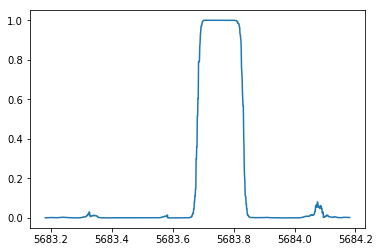

In [57]:
print(output2.call_times[500,])
i0 = 2083682

plt.plot(output2.times[(i0-500):(i0+500)],output2.scores[(i0-500):(i0+500)])

In [50]:
output2.times[2083682]

3600.0